In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pickle
import time

In [2]:
sigma = torch.tensor(0.1)

In [3]:
device = torch.device('cpu')

# Define the exact solution
def exact_solution(x, t):
    return torch.sin(x)*torch.cos(pi*t)

def initial_condition(x):
    return torch.sin(x)*(1 + sigma*torch.randn(x.shape)).to(device)

def initial_condition_t(x):
    return 0*torch.cos(x)


In [4]:
# assigning number of points
initial_pts = 500
left_boundary_pts = 500
right_boundary_pts = 500
residual_pts = 10000

# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

x_init = 8*pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init = torch.cat([x_init, t_init],1).to(device)
u_init = initial_condition(init[:,0]).reshape(-1, 1)
u_init_t = 0*initial_condition(init[:,0]).reshape(-1, 1)

xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) #
b_left = torch.cat([xb_left, tb_left ],1).to(device)
u_b_l = 0*torch.sin(tb_left)

xb_right = 8*pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1).to(device)
u_b_r = 0*torch.sin(2*pi - tb_right)

x_interior = 8*pi*torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1).to(device)

training_set = DataLoader(torch.utils.data.TensorDataset(init.to(device), u_init.to(device), u_init_t.to(device), b_left.to(device),  b_right.to(device), u_b_l.to(device), u_b_r.to(device)), batch_size=500, shuffle=False)


In [5]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)



In [6]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = u_init.shape[1], n_hidden_layers=4, neurons=200)
model_state_dict = torch.load('PINN_EB.pth', map_location=torch.device('cpu'))
my_network = my_network.to(device)

# def init_xavier(model, retrain_seed):
#     torch.manual_seed(retrain_seed)
#     def init_weights(m):
#         if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
#             g = nn.init.calculate_gain('tanh')
#             torch.nn.init.xavier_uniform_(m.weight, gain=g)
#             #torch.nn.init.xavier_normal_(m.weight, gain=g)
#             m.bias.data.fill_(0)
#     model.apply(init_weights)

# # Random Seed for weight initialization
# retrain = 128
# # Xavier weight initialization
# init_xavier(my_network, retrain)

if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")


def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (initial, u_initial, u_initial_t, bd_left, bd_right, ubl, ubr) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                u_initial_pred_ = model(initial)
                inputs = torch.ones(initial_pts, 1).to(device)
                grad_u_init = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inputs, create_graph=True)[0]
                u_init_t = grad_u_init[:, 1].reshape(-1, )

                # for left boundary
                bd_left.requires_grad = True
                bd_left_pred_ = model(bd_left)
                inputs = torch.ones(left_boundary_pts, 1).to(device)
                grad_bd_left = torch.autograd.grad(bd_left_pred_, bd_left, grad_outputs=inputs, create_graph=True)[0]
                u_bd_x_left = grad_bd_left[:, 0].reshape(-1, )
                inputs = torch.ones(left_boundary_pts, 1).reshape(-1, ).to(device)
                grad_u_bd_x_left = torch.autograd.grad(u_bd_x_left, bd_left, grad_outputs=inputs, create_graph=True)[0]
                u_bd_xx_left = grad_u_bd_x_left[:, 0].reshape(-1, )
                inputs = torch.ones(left_boundary_pts, 1).reshape(-1, ).to(device)
                grad_u_bd_xx_left = torch.autograd.grad(u_bd_xx_left, bd_left, grad_outputs=inputs, create_graph=True)[0]
                u_bd_xxx_left = grad_u_bd_xx_left[:, 0].reshape(-1, )

                # for right boundary
                bd_right.requires_grad = True
                bd_right_pred_ = model(bd_right)
                inputs = torch.ones(right_boundary_pts, 1).to(device)
                grad_bd_right = torch.autograd.grad(bd_right_pred_, bd_right, grad_outputs=inputs, create_graph=True)[0]
                u_bd_x_right = grad_bd_right[:, 0].reshape(-1, )
                inputs = torch.ones(right_boundary_pts, 1).reshape(-1, ).to(device)
                grad_u_bd_x_right = torch.autograd.grad(u_bd_x_right, bd_right, grad_outputs=inputs, create_graph=True)[0]
                u_bd_xx_right = grad_u_bd_x_right[:, 0].reshape(-1, )

                # residual calculation
                interior.requires_grad = True
                u_hat = model(interior)
                inputs = torch.ones(residual_pts, 1).to(device)
                grad_u_hat = torch.autograd.grad(u_hat, interior, grad_outputs=inputs, create_graph=True)[0]

                u_x = grad_u_hat[:, 0].reshape(-1, )
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]
                u_xx = grad_u_x[:, 0].reshape(-1, )
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_xx = torch.autograd.grad(u_xx, interior, grad_outputs=inputs, create_graph=True)[0]
                u_xxx = grad_u_xx[:, 0].reshape(-1, )
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_xxx = torch.autograd.grad(u_xxx, interior, grad_outputs=inputs, create_graph=True)[0]
                u_xxxx = grad_u_xxx[:, 0].reshape(-1, )

                u_t = grad_u_hat[:, 1]
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_t = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]
                u_tt = grad_u_t[:, 1].reshape(-1, )

                # Item 1. below

                loss_ic = torch.mean((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )) ** p) + \
                          torch.mean((u_init_t.reshape(-1, )) ** p)
                loss_pde = torch.mean((u_tt.reshape(-1, ) + u_xxxx.reshape(-1, ) - (2-pi**2)*torch.sin(interior[:,0])*torch.cos(pi*interior[:,1])) ** p)
                loss_left_b = torch.mean((u_bd_x_left.reshape(-1, ) - ubl.reshape(-1, )) ** p) + \
                              torch.mean((u_bd_xx_left.reshape(-1, ) - ubl.reshape(-1, )) ** p)
                loss_right_b = torch.mean((bd_right_pred_.reshape(-1, ) - ubr.reshape(-1, )) ** p) + \
                               torch.mean((u_bd_xx_right.reshape(-1, ) - ubr.reshape(-1, )) ** p)

                loss = loss_ic + loss_pde + loss_left_b + loss_right_b

                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [7]:
n_epochs = 1500
start_time = time.time()
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )
end_time = time.time()
total_time = end_time - start_time
print("Training time: {:.2f} seconds".format(total_time))


with open('PINN_10_noise_tl.pkl', 'wb') as f:
    pickle.dump(history, f)

f.close()

model_state_dict = my_network.state_dict()

# Save the model state dictionary to a file
torch.save(model_state_dict, 'PINN_10_noise_tl.pth')


################################  0  ################################


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:234: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return Variable._execution_engine.run_backward(


Loss:  16.15862274169922
################################  1  ################################
Loss:  16.158414840698242
################################  2  ################################
Loss:  16.157577514648438
################################  3  ################################
Loss:  16.156471252441406
################################  4  ################################
Loss:  16.15506935119629
################################  5  ################################
Loss:  16.153337478637695
################################  6  ################################
Loss:  16.151254653930664
################################  7  ################################
Loss:  16.148792266845703
################################  8  ################################
Loss:  16.145896911621094
################################  9  ################################
Loss:  16.142431259155273
################################  10  ################################
Loss:  16.137996673583984
###############

Loss:  12.63329792022705
################################  86  ################################
Loss:  12.59334659576416
################################  87  ################################
Loss:  12.552593231201172
################################  88  ################################
Loss:  12.511739730834961
################################  89  ################################
Loss:  12.474047660827637
################################  90  ################################
Loss:  12.438776016235352
################################  91  ################################
Loss:  12.406279563903809
################################  92  ################################
Loss:  12.37635326385498
################################  93  ################################
Loss:  12.348550796508789
################################  94  ################################
Loss:  12.321192741394043
################################  95  ################################
Loss:  12.294119834899902
#######

Loss:  10.510775566101074
################################  170  ################################
Loss:  10.49143123626709
################################  171  ################################
Loss:  10.477712631225586
################################  172  ################################
Loss:  10.464714050292969
################################  173  ################################
Loss:  10.45249080657959
################################  174  ################################
Loss:  10.440155982971191
################################  175  ################################
Loss:  10.428500175476074
################################  176  ################################
Loss:  10.416438102722168
################################  177  ################################
Loss:  10.403836250305176
################################  178  ################################
Loss:  10.390334129333496
################################  179  ################################
Loss:  10.375744819641

Loss:  9.386110305786133
################################  255  ################################
Loss:  9.376408576965332
################################  256  ################################
Loss:  9.366679191589355
################################  257  ################################
Loss:  9.357331275939941
################################  258  ################################
Loss:  9.348204612731934
################################  259  ################################
Loss:  9.339666366577148
################################  260  ################################
Loss:  9.331358909606934
################################  261  ################################
Loss:  9.323471069335938
################################  262  ################################
Loss:  9.315692901611328
################################  263  ################################
Loss:  9.30806827545166
################################  264  ################################
Loss:  9.300535202026367
######

Loss:  8.73745346069336
################################  340  ################################
Loss:  8.727364540100098
################################  341  ################################
Loss:  8.718502044677734
################################  342  ################################
Loss:  8.709537506103516
################################  343  ################################
Loss:  8.702496528625488
################################  344  ################################
Loss:  8.696626663208008
################################  345  ################################
Loss:  8.688704490661621
################################  346  ################################
Loss:  8.68043327331543
################################  347  ################################
Loss:  8.670685768127441
################################  348  ################################
Loss:  8.661221504211426
################################  349  ################################
Loss:  8.649016380310059
#######

Loss:  7.47746467590332
################################  425  ################################
Loss:  7.462278366088867
################################  426  ################################
Loss:  7.444904327392578
################################  427  ################################
Loss:  7.429030418395996
################################  428  ################################
Loss:  7.414653301239014
################################  429  ################################
Loss:  7.401580810546875
################################  430  ################################
Loss:  7.3892645835876465
################################  431  ################################
Loss:  7.377867221832275
################################  432  ################################
Loss:  7.366848468780518
################################  433  ################################
Loss:  7.356223106384277
################################  434  ################################
Loss:  7.346603870391846
#####

Loss:  6.723687171936035
################################  510  ################################
Loss:  6.72071647644043
################################  511  ################################
Loss:  6.7174787521362305
################################  512  ################################
Loss:  6.714106559753418
################################  513  ################################
Loss:  6.710633754730225
################################  514  ################################
Loss:  6.707064151763916
################################  515  ################################
Loss:  6.703409671783447
################################  516  ################################
Loss:  6.699874401092529
################################  517  ################################
Loss:  6.696496963500977
################################  518  ################################
Loss:  6.693207263946533
################################  519  ################################
Loss:  6.690019130706787
#####

Loss:  6.394594669342041
################################  595  ################################
Loss:  6.391903400421143
################################  596  ################################
Loss:  6.389125347137451
################################  597  ################################
Loss:  6.386438846588135
################################  598  ################################
Loss:  6.383725643157959
################################  599  ################################
Loss:  6.381019115447998
################################  600  ################################
Loss:  6.378300189971924
################################  601  ################################
Loss:  6.37562370300293
################################  602  ################################
Loss:  6.373012542724609
################################  603  ################################
Loss:  6.370527744293213
################################  604  ################################
Loss:  6.368130683898926
######

Loss:  6.053913116455078
################################  680  ################################
Loss:  6.04955530166626
################################  681  ################################
Loss:  6.044833660125732
################################  682  ################################
Loss:  6.039730072021484
################################  683  ################################
Loss:  6.034572601318359
################################  684  ################################
Loss:  6.029504776000977
################################  685  ################################
Loss:  6.024832725524902
################################  686  ################################
Loss:  6.020561695098877
################################  687  ################################
Loss:  6.016807556152344
################################  688  ################################
Loss:  6.013449668884277
################################  689  ################################
Loss:  6.010411262512207
######

Loss:  5.837794303894043
################################  765  ################################
Loss:  5.835873603820801
################################  766  ################################
Loss:  5.833878517150879
################################  767  ################################
Loss:  5.83186149597168
################################  768  ################################
Loss:  5.829667568206787
################################  769  ################################
Loss:  5.8274827003479
################################  770  ################################
Loss:  5.8250627517700195
################################  771  ################################
Loss:  5.822494983673096
################################  772  ################################
Loss:  5.819838523864746
################################  773  ################################
Loss:  5.817320823669434
################################  774  ################################
Loss:  5.814767360687256
#######

Loss:  5.649472236633301
################################  850  ################################
Loss:  5.647860050201416
################################  851  ################################
Loss:  5.646220684051514
################################  852  ################################
Loss:  5.644473075866699
################################  853  ################################
Loss:  5.642745494842529
################################  854  ################################
Loss:  5.641207695007324
################################  855  ################################
Loss:  5.6391754150390625
################################  856  ################################
Loss:  5.6371541023254395
################################  857  ################################
Loss:  5.634256362915039
################################  858  ################################
Loss:  5.631436347961426
################################  859  ################################
Loss:  5.628804683685303
###

Loss:  5.47305965423584
################################  935  ################################
Loss:  5.471864223480225
################################  936  ################################
Loss:  5.470722198486328
################################  937  ################################
Loss:  5.469638824462891
################################  938  ################################
Loss:  5.468575954437256
################################  939  ################################
Loss:  5.467545986175537
################################  940  ################################
Loss:  5.466516494750977
################################  941  ################################
Loss:  5.465468883514404
################################  942  ################################
Loss:  5.464369773864746
################################  943  ################################
Loss:  5.463167190551758
################################  944  ################################
Loss:  5.461981773376465
######

Loss:  5.340047836303711
################################  1020  ################################
Loss:  5.337905406951904
################################  1021  ################################
Loss:  5.335677146911621
################################  1022  ################################
Loss:  5.333754539489746
################################  1023  ################################
Loss:  5.331718921661377
################################  1024  ################################
Loss:  5.329344749450684
################################  1025  ################################
Loss:  5.327345371246338
################################  1026  ################################
Loss:  5.3252081871032715
################################  1027  ################################
Loss:  5.322749137878418
################################  1028  ################################
Loss:  5.3206706047058105
################################  1029  ################################
Loss:  5.318898677

Loss:  5.217504978179932
################################  1104  ################################
Loss:  5.216195583343506
################################  1105  ################################
Loss:  5.214869976043701
################################  1106  ################################
Loss:  5.213536262512207
################################  1107  ################################
Loss:  5.212207317352295
################################  1108  ################################
Loss:  5.210938453674316
################################  1109  ################################
Loss:  5.209729194641113
################################  1110  ################################
Loss:  5.208558082580566
################################  1111  ################################
Loss:  5.207432746887207
################################  1112  ################################
Loss:  5.20636510848999
################################  1113  ################################
Loss:  5.205358028411

Loss:  5.132529258728027
################################  1188  ################################
Loss:  5.131740093231201
################################  1189  ################################
Loss:  5.131031036376953
################################  1190  ################################
Loss:  5.130378723144531
################################  1191  ################################
Loss:  5.129773139953613
################################  1192  ################################
Loss:  5.1291704177856445
################################  1193  ################################
Loss:  5.128529071807861
################################  1194  ################################
Loss:  5.1279730796813965
################################  1195  ################################
Loss:  5.1274871826171875
################################  1196  ################################
Loss:  5.1270246505737305
################################  1197  ################################
Loss:  5.1265544

Loss:  5.040938377380371
################################  1272  ################################
Loss:  5.039690017700195
################################  1273  ################################
Loss:  5.038422107696533
################################  1274  ################################
Loss:  5.037041187286377
################################  1275  ################################
Loss:  5.03580904006958
################################  1276  ################################
Loss:  5.034656524658203
################################  1277  ################################
Loss:  5.033303737640381
################################  1278  ################################
Loss:  5.032153606414795
################################  1279  ################################
Loss:  5.0308685302734375
################################  1280  ################################
Loss:  5.029524803161621
################################  1281  ################################
Loss:  5.02817487716

Loss:  4.975066661834717
################################  1356  ################################
Loss:  4.974427700042725
################################  1357  ################################
Loss:  4.97362756729126
################################  1358  ################################
Loss:  4.972786903381348
################################  1359  ################################
Loss:  4.971896648406982
################################  1360  ################################
Loss:  4.970898628234863
################################  1361  ################################
Loss:  4.969926834106445
################################  1362  ################################
Loss:  4.968915939331055
################################  1363  ################################
Loss:  4.967877388000488
################################  1364  ################################
Loss:  4.966888427734375
################################  1365  ################################
Loss:  4.965925693511

Loss:  4.923158168792725
################################  1440  ################################
Loss:  4.922417640686035
################################  1441  ################################
Loss:  4.921768665313721
################################  1442  ################################
Loss:  4.921136379241943
################################  1443  ################################
Loss:  4.920490264892578
################################  1444  ################################
Loss:  4.919816017150879
################################  1445  ################################
Loss:  4.919093608856201
################################  1446  ################################
Loss:  4.918352127075195
################################  1447  ################################
Loss:  4.917632579803467
################################  1448  ################################
Loss:  4.916928291320801
################################  1449  ################################
Loss:  4.91617631912

In [ ]:
# # loading model

# # Load the history from the pickle file
# with open('PINN_EB.pkl', 'rb') as f:
#     history = pickle.load(f)

# # # Load the model architecture
# # my_network = your_model_module.YourModelClass()  # Instantiate your model class

# # Load the saved model state dictionary
# model_state_dict = torch.load('PINN_EB.pth',  map_location=torch.device('cpu'))

# # Load the model weights
# my_network.load_state_dict(model_state_dict)


In [8]:
x_test = torch.linspace(0, 8*pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution(x_test, t_test).reshape(-1,1)
my_network = my_network.cpu()
u_test_pred = my_network(test).reshape(-1,1)

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")


Relative Error Test:  64.63039517402649 %


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

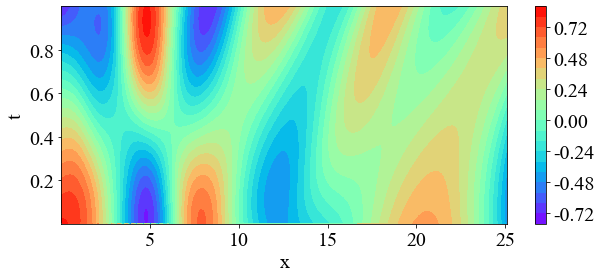

In [9]:
x_test = 8*pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test).reshape(-1,1)
relative_error = torch.abs(u_test_pred - u_test)
u_test = u_test.reshape(-1,)

# reshaping and detach numpy
x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error = relative_error.reshape(-1,)
u_test_pred = u_test_pred.reshape(-1, )

x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
u_test_pred = u_test_pred.detach().numpy()
relative_error = relative_error.detach().numpy()





plt.rcParams['figure.figsize'] = [10, 4]

from matplotlib.font_manager import FontProperties
plt.rcParams['axes.unicode_minus'] = False
font_path = 'times-new-roman.ttf'

custom_font = FontProperties(fname=font_path)


        
CS1 = plt.tricontourf(x_test, t_test, u_test_pred, 20, cmap='rainbow')
#CS1 = plt.tricontourf(x_test, t_test, u_test, 20, cmap='rainbow')
#CS1 = plt.tricontourf(x_test, t_test, relative_error, 20, cmap='rainbow')



cbar1 = plt.colorbar(CS1)
for t in cbar1.ax.get_yticklabels():
    t.set_fontproperties(custom_font)
    t.set_fontsize(20)



plt.xlabel('x', fontsize=20, fontproperties=custom_font)
plt.ylabel('t', fontsize=20, fontproperties=custom_font)
plt.xticks(fontsize=20, fontproperties=custom_font)
plt.yticks(fontsize=20, fontproperties=custom_font)
#plt.savefig('PINN_EB.pdf', dpi = 300, bbox_inches = "tight")
#plt.savefig('Exact_EB.pdf', dpi = 300, bbox_inches = "tight")
#plt.savefig('Absolute_error_EB.pdf', dpi = 300, bbox_inches = "tight")

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

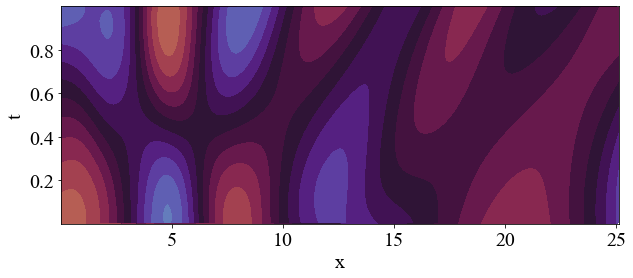

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Assuming you have imported your data and defined necessary functions

# Rest of your code...

# # Convert the font size to points
font_size = 20
# ticks_font = FontProperties(family='Times New Roman', style='normal', size=font_size)





x_test = 8*pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test).reshape(-1,1)
relative_error = torch.abs(u_test_pred - u_test)
u_test = u_test.reshape(-1,)

# reshaping and detach numpy
x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error = relative_error.reshape(-1,)
u_test_pred = u_test_pred.reshape(-1, )

x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
u_test_pred = u_test_pred.detach().numpy()
relative_error = relative_error.detach().numpy()





plt.rcParams['figure.figsize'] = [10, 4]

from matplotlib.font_manager import FontProperties
plt.rcParams['axes.unicode_minus'] = False
font_path = 'times-new-roman.ttf'

ticks_font = FontProperties(fname=font_path)

# Define the levels for contouring
levels = np.linspace(-1.5, 1.5, 20)

        
CS1 = plt.tricontourf(x_test, t_test, u_test_pred, levels, cmap='twilight')
#CS1 = plt.tricontourf(x_test, t_test, u_test, 20, cmap='twilight')
#CS1 = plt.tricontourf(x_test, t_test, relative_error, 20, cmap='rainbow')



#cbar1 = plt.colorbar(CS1)
for t in cbar1.ax.get_yticklabels():
    t.set_fontproperties(custom_font)
    t.set_fontsize(20)



plt.xlabel('x', fontsize=20, fontproperties=custom_font)
plt.ylabel('t', fontsize=20, fontproperties=custom_font)
plt.xticks(fontsize=20, fontproperties=custom_font)
plt.yticks(fontsize=20, fontproperties=custom_font)
#plt.savefig('Causal_EB.pdf', dpi = 300, bbox_inches = "tight")
#plt.savefig('PINN_EB.pdf', dpi=500, bbox_inches="tight", format='pdf', backend='cairo')
#plt.savefig('Absolute_error_EB.pdf', dpi = 300, bbox_inches = "tight")


